Symbols aus Watchlist aus Tradingview
Historische Preise zu den Symbols von yh yahoo, sofern nötig, mit Zwischenspeicher, da begrenzte Umsonstabfragen
Vernüftiges Lambda pro Symbol bestimmen, z.B. <12 Trendwechsel im Jahr?, Lambda pro Symbol abspeichern
Trendwechsel abspeichern (Feststellen ob die Trendwechsel mit neuen Daten auch in der Vergangenheit entstehen können? Ob sich das ganze mit neuen Daten verschiebt)
Darstellung, plots pro symbol eine column

In [1]:
import pandas as pd
import numpy as np
import cvxpy 
import scipy
import cvxopt 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import matplotlib
import matplotlib.cm as cm
from matplotlib import patheffects
import requests
import glob
import os
import datetime
import sqlite3
import pricesdb

functions für den DB Teil

In [2]:
def get_historical_data(symbol, region):
    """
    get data from yahoo
    or read from disc
    """

    url = "https://yh-finance.p.rapidapi.com/stock/v3/get-historical-data"
    querystring = {"symbol":symbol,"region":region}
    headers = {
        "X-RapidAPI-Key": '', # hier muss der APIKey hinein, oder in die Umgebungsvariable X-RapidAPI-Key
        "X-RapidAPI-Host": "yh-finance.p.rapidapi.com"
    }
    if headers.get('X-RapidAPI-Key') == '':
         headers = {
            "X-RapidAPI-Key": os.environ.get('X_RapidAPI_Key'),
            "X-RapidAPI-Host": "yh-finance.p.rapidapi.com"
         }

    if headers.get('X-RapidAPI-Key') == '':
        print('No API Key found in env variable X-RapidAPI-Key')
        return

    response = requests.request("GET", url, headers=headers, params=querystring)
    if response.status_code != 200:
        print(f'No valid JSON response for {symbol}_{region}')
        return None, response.status_code
    
    df = response.json()
    df1 = pd.json_normalize(df)
    return df1, response.status_code

In [3]:
def get_prices_update_dbs(symbol, region):
    print(f'{symbol}_{region}')    
    # raw_prices aus rapi
    raw_prices, status_code = get_historical_data(symbol,region)
    print('status_code:' + str(status_code) + ' raw_prices:' + str(raw_prices)[:100] )
    if raw_prices is None:
        print(f'No prices found in JSON response for {symbol}_{region}, status_code:{status_code}')
        return None
    if len(raw_prices.columns) ==0:
        print(f'No prices found in JSON response for {symbol}_{region}, status_code:{status_code}')
        return None
    # ist in raw_prices['prices'][0] etwas drin
    if raw_prices['prices'][0] == []:
        print(f'No prices found in JSON response for {symbol}_{region}, status_code:{status_code}')
        return None        

    # connection 
    # bei neuem symbol wird automatisch eine neue db generiert
    conn = pricesdb.create_connection(r"data/"+symbol+"_"+region+".db")

    prices = pd.DataFrame(raw_prices['prices'][0])
    # Spalten ergänzen
    prices['symbol'] = symbol
    prices['region'] = region
    # Datümer umwandeln
    prices['date'] = pd.to_datetime(prices['date'], unit='s')
    prices['updatedt'] = datetime.datetime.today()
    # events abspalten - nur wenn es keine Index ist - es events überhaupt gibt
    eventsavailable = False
    if 'type' in prices.columns:
        eventsavailable = True
        # null Spalten löschen
        events = prices[pd.notnull(prices['type'])]
        prices = prices[pd.isnull(prices['type'])]
        events = events.drop(['open', 'high', 'low', 'close', 'volume', 'adjclose'], axis= 1)
        prices = prices.drop(['adjclose', 'amount', 'type', 'data'], axis=1)    

    # schon vorhandene aus DB löschen
    dates = prices['date'].drop_duplicates()
    datesl = [str(date) for date in dates]

    # prices in db schreiben
    pricesdb.delete_tableentries(conn, 'prices', symbol, region, str(datesl)[1:-1])
    if eventsavailable == False:
        prices = prices.drop(['adjclose'], axis=1)
    prices.to_sql('prices', conn, if_exists='append' , index=False)
    if eventsavailable ==  True:
        # auch für events schon vorhandene aus DB löschen
        e_dates = events['date'].drop_duplicates()
        e_datesl = [str(e_date) for e_date in e_dates]
        # events in db schreiben
        pricesdb.delete_tableentries(conn, 'events', symbol, region,  str(e_datesl)[1:-1])
        events.to_sql('events', conn, if_exists='append' , index=False)
    print(f'DB updated for {symbol}_{region}')
    return conn

symbols in controllist laden und die dazugehörigen prices und events aus API holen und in DBs speichern

In [4]:
# Symbols aus Watchlist
watchlist = pd.read_csv('watchlist.csv', sep=';')
group = 10

controllist = watchlist[watchlist['group'] == group].reset_index()
print(controllist)
for i in range(len(controllist)):
    print(controllist['tradv_ticker'][i])
    symbol = controllist['tradv_ticker'][i]
    symbol = controllist['yahoo_symbol'][i]
    region = controllist['region'][i]
    
    conn = get_prices_update_dbs(symbol, region)

    index tradv_ticker region  rapi_response_code yahoo_symbol  group  \
0       0         ACWI     US               200.0         ACWI   10.0   
1       1         URTH     US               200.0         URTH   10.0   
2       2          NDX     US               200.0         ^NDX   10.0   
3       4          SPX     US               200.0        ^GSPC   10.0   
4       6          RUT     US               200.0         ^RUT   10.0   
5       7          DJR     US               302.0         ^DJR   10.0   
6       8        NI225     JP               302.0        ^N225   10.0   
7      10          HSI     HK               302.0         ^HSI   10.0   
8      12       SENSEX     US                 NaN       ^BSESN   10.0   
9      13          SMI     US                 NaN        ^SSMI   10.0   
10     17        DEU40     US                 NaN       ^GDAXI   10.0   

    Unnamed: 5  Unnamed: 6  
0          NaN           0  
1          NaN           1  
2          NaN           2  
3      

symbols in controllist aus watchlist neu laden

In [4]:
# nur zum Nachladen
watchlist = pd.read_csv('watchlist.csv', sep=';')
controllist = watchlist[watchlist['group'] == 10].reset_index()
controllist,range(len(controllist))

(    index tradv_ticker region  rapi_response_code yahoo_symbol  group  \
 0       0         ACWI     US               200.0         ACWI   10.0   
 1       1         URTH     US               200.0         URTH   10.0   
 2       2          NDX     US               200.0         ^NDX   10.0   
 3       4          SPX     US               200.0        ^GSPC   10.0   
 4       6          RUT     US               200.0         ^RUT   10.0   
 5       7          DJR     US               302.0         ^DJR   10.0   
 6       8        NI225     JP               302.0        ^N225   10.0   
 7      10          HSI     HK               302.0         ^HSI   10.0   
 8      12       SENSEX     US                 NaN       ^BSESN   10.0   
 9      13          SMI     US                 NaN        ^SSMI   10.0   
 10     17        DEU40     US                 NaN       ^GDAXI   10.0   
 
     Unnamed: 5  Unnamed: 6  
 0          NaN           0  
 1          NaN           1  
 2          NaN     

functions für den calculations Teil

In [5]:
def calc_trendlines(y, lambda_list, solver, reg_norm):
    """die trendlines für die lambdas berechnen"""
    n = y.size
    ones_row = np.ones((1, n))
    D = scipy.sparse.spdiags(np.vstack((ones_row, -2*ones_row, ones_row)), range(3), n-2, n)

    trendlinesl = []
    #trendlinesd = pd.DataFrame()
    trendchangesl = []
    #trendchangesd = pd.DataFrame()
    aggtchanges1 = []
    for i, lambda_value in enumerate(lambda_list):
        x = cvxpy.Variable(shape=n)     # x is the filtered trend that we initialize    
        objective = cvxpy.Minimize(0.5 * cvxpy.sum_squares(y-x) 
                    + lambda_value * cvxpy.norm(D@x, reg_norm))    # Note: D@x is syntax for matrix multiplication    
        problem = cvxpy.Problem(objective)
        problem.solve(solver=solver, verbose=False)

        trendlinesl.append(np.array(x.value))
        
        # trendlined = pd.DataFrame(np.array(x.value), columns=['trendline'])
        # trendlined['lambda_value'] = lambda_value
        # trendlinesd = pd.concat(trendlinesd, trendlined)

        # trendchanges index
        r = np.abs(np.diff(np.diff(np.array(x.value))))
        r75, r25 = np.percentile(r,[75,25])
        iqr = r75 - r25
        trendchanges = np.where(r > r75 + 100*iqr)[0]
        #trendchanges = dates[np.where(r > r75 + 1000*iqr)[0]].to_list()
        trendchangesl.append(trendchanges)

    return trendlinesl, trendchangesl

In [6]:
def transform_calc_trendlines(prices, lambda_list, solver, reg_norm):
    """
    transforms und executes calculation, from one df of prices with lists of lambdas and 
    returns a list x values dfs and trendchanges df, where x changes Steigung (Trend) 
    prices: df with columns date und close
    lambda_list:
    """
    # prices umdrehen links frühes Datum rechts späteres
    prices = prices.sort_values(by='date',ascending=True)
    # drop 
    prices = prices.dropna(subset=['close'])
    close_prices = prices['close'].copy().to_numpy()
    #close_prices.index = pd.to_datetime(prices['date'])
    #y = pd.DataFrame(y, index= pd.to_datetime(prices['date']))
    #close_prices = close_prices.to_numpy()
    # log warum eigentlich? Ohne log scheint der Algorithmus instabil zu sein? 
    #close_prices = np.log(close_prices)
    # Versuch mit Skalierung auf 1
    factor = close_prices[0] # bei 1 geht es los
    close_prices *=(1.0/factor)

    trendlinesl, trendchangesl = calc_trendlines(close_prices, lambda_list, solver, reg_norm)
    # Datümer wieder ergänzen
    trendlinedl = []
    trendchangesdl = []
    for i, (trendline, trendchanges) in enumerate(zip(trendlinesl, trendchangesl)):
        trendlined = pd.DataFrame(trendline,pd.to_datetime(prices['date']))
        trendlinedl.append(trendlined)
        trendchangesd = pd.to_datetime(prices.iloc[trendchanges]['date'])
        trendchangesdl.append(trendchangesd)
    
    prices['close_start_1'] = close_prices

    return prices, trendlinedl, trendchangesdl


für alle symbols in der controllist, prices aus DB holen und alle calculations produzieren

In [7]:
def get_prices_from_db(dbfile :str, fromdate :str = str(int(datetime.datetime.now().date().strftime('%Y')) -1) + '-' + datetime.datetime.now().date().strftime('%m') +'-'+ '01'):
    conn = pricesdb.create_connection(dbfile)
    if conn is None:
        exit()
    datetime.datetime.date
    #prices = pd.read_sql_query("SELECT * FROM prices", conn)
    # das letzte Jahr vom Anfang des aktuellen Monats, sonst kann man die x Achsen Beschriftung nicht mehr lesen
    sql = "SELECT * FROM prices where date>='" + fromdate + "'"
    prices = pd.read_sql_query(sql,conn)

    prices_sorted = prices.sort_values(['date'])
    prices_sorted = prices_sorted.reset_index(drop=True)
    return prices_sorted

In [8]:
# Hauptroutine
# all together now
# alle vorhandenen DBs lesen und die Trends rechnen und darstellen 
lambda_list = [1]
#lambda_list = [0, 0.1, 0.5, 1, 2, 5, 10, 50, 200, 500, 1000, 2000, 5000, 10000, 100000]
#lambda_list = [0.1, 0.5, 1, 2, 5, 10]
solver = cvxpy.CVXOPT
reg_norm = 1

pricesdl = []
trendlinedll = []
trendchangesdll = []

prev_pricesdl = []
prev_trendlinedll = []
prev_trendchangesdll = []

num_runs = 0

prev_dist=5 # week

for i in range(len(controllist)):
    f = glob.glob(r"data/"+controllist['yahoo_symbol'][i] + "_*.db")[0]
    prices_sorted = get_prices_from_db(f)
    
    pricesd, trendlinedl, trendchangesdl = transform_calc_trendlines(prices_sorted, lambda_list, solver, reg_norm)
    pricesdl.append(pricesd)
    trendlinedll.append(trendlinedl)
    trendchangesdll.append(trendchangesdl)

    prev_prices_sorted = prices_sorted[:- prev_dist]
    prev_pricesd, prev_trendlinedl, prev_trendchangesdl = transform_calc_trendlines(prev_prices_sorted, lambda_list, solver, reg_norm)
    prev_pricesdl.append(prev_pricesd)
    prev_trendlinedll.append(prev_trendlinedl)
    prev_trendchangesdll.append(prev_trendchangesdl)

    num_runs = num_runs + 1

db_file:data\ACWI_US.db
db_file:data\URTH_US.db
db_file:data\^NDX_US.db
db_file:data\^GSPC_US.db
db_file:data\^RUT_US.db
db_file:data\^DJR_US.db
db_file:data\^N225_JP.db
db_file:data\^HSI_HK.db
db_file:data\^BSESN_US.db
db_file:data\^SSMI_US.db
db_file:data\^GDAXI_US.db


Erweiterung:
<ul>
<li>trend slope change zur vorherigen trendline ausrechnen und als diff darstellen 
<li>wenn der trend slope change gross und positiv ist dann ist das ist das der erste Teil eines Kaufsignals
<li>vorher eng aneinanderliegende trendchanges (+-2) als einer zusammenführen
<li>diff aktKurs zu trendline ausrechnen und darstellen
<li>wenn der aktuelle price unter der trendline liegt ist das der zweite Teil des Kaufsignals
<li>eventuell stddev von trendline-close_price ausrechnen um zu bestimmen ob man warten soll bis der aktuelle price <li>unter die trendline fällt
</ul>  


In [9]:
def calc_bs_signals(trendchangesd, trendlined):
    aggtchanges = trendchangesd.to_frame()
    aggtchanges['orig_index'] = aggtchanges.index
    aggtchanges = pd.merge(aggtchanges, trendlined[trendlined.index.isin(aggtchanges['date'])], on='date', how='left')
    aggtchanges['datediff'] = aggtchanges['date'].diff(periods=-1)
    aggtchanges = aggtchanges[(aggtchanges['datediff'] < datetime.timedelta(-2.0)) | aggtchanges['datediff'].isnull()]
    aggtchanges.index = aggtchanges['date']
    aggtchanges.columns = ['date','orig_index','trendlinevalue', 'diffdate']
    #trendlined.columns = ['trendlinevalue']
    #aggtchanges = pd.merge(aggtchanges, trendlined[trendlined.index == trendlined.index.max()], on='date', how='outer')
    trd = trendlined[trendlined.index == trendlined.index.max()]
    trd.columns = ['trendlinevalue']
    aggtchanges = pd.concat([aggtchanges,trd])
    trd = trendlined[trendlined.index == trendlined.index.min()]
    trd.columns = ['trendlinevalue']
    aggtchanges = pd.concat([aggtchanges,trd])    
    aggtchanges['date'] = aggtchanges.index # damit auch der erste und der letzte ein Wert in ['date'] hat
    aggtchanges = aggtchanges.sort_index()
    aggtchanges['slope_until'] = aggtchanges['trendlinevalue'].diff()#/aggtchanges['date'].diff(periods=1).dt.days
    aggtchanges['slopechange'] = aggtchanges['slope_until'].shift(-1) - aggtchanges['slope_until'] 
    #aggtchanges['slopechange1'] = aggtchanges['slope_until'].diff()
    aggtchanges['buy']  = (aggtchanges['slope_until']<0) & (aggtchanges['slope_until'].shift(-1)>0) #'kaufen'
    aggtchanges['sell'] = (aggtchanges['slope_until']>0) & (aggtchanges['slope_until'].shift(-1)<0) #'verkaufen'

    return aggtchanges

function für die Darstellung

In [10]:
def calc_slope_diff(trendchangesd, prev_trendchangesd, trendlined, prev_trendlined):
    # neue Events
    # 
    new_trendchng = trendchangesd[trendchangesd > prev_trendchangesd.max()].values
    #new_trendchngs = new_trendchng.dt.strftime('%Y-%m-%d').item().to_list()
    # Steigung
    # jeweils vom letzten - nicht vom letzten gemeinsamen 
    timedelta = trendlined.index.max() - trendchangesd.max()
    st_trend = (trendlined[trendlined.index==trendlined.index.max()][0].item() - trendlined[trendlined.index==trendchangesd.max()][0].item())/timedelta.days
    prev_timedelta = prev_trendlined.index.max() - prev_trendchangesd.max()
    st_prev_trend = (prev_trendlined[prev_trendlined.index==prev_trendlined.index.max()][0].item() - prev_trendlined[prev_trendlined.index==prev_trendchangesd.max()][0].item())/prev_timedelta.days
    diff_st_trend = st_trend - st_prev_trend 
    
    #print(new_trendchng, diff_st_trend, prev_trendchangesd.shape, trendchangesd.shape)
    
    return new_trendchng, diff_st_trend, st_trend, st_prev_trend


die calculation Ergebnisse darstellen

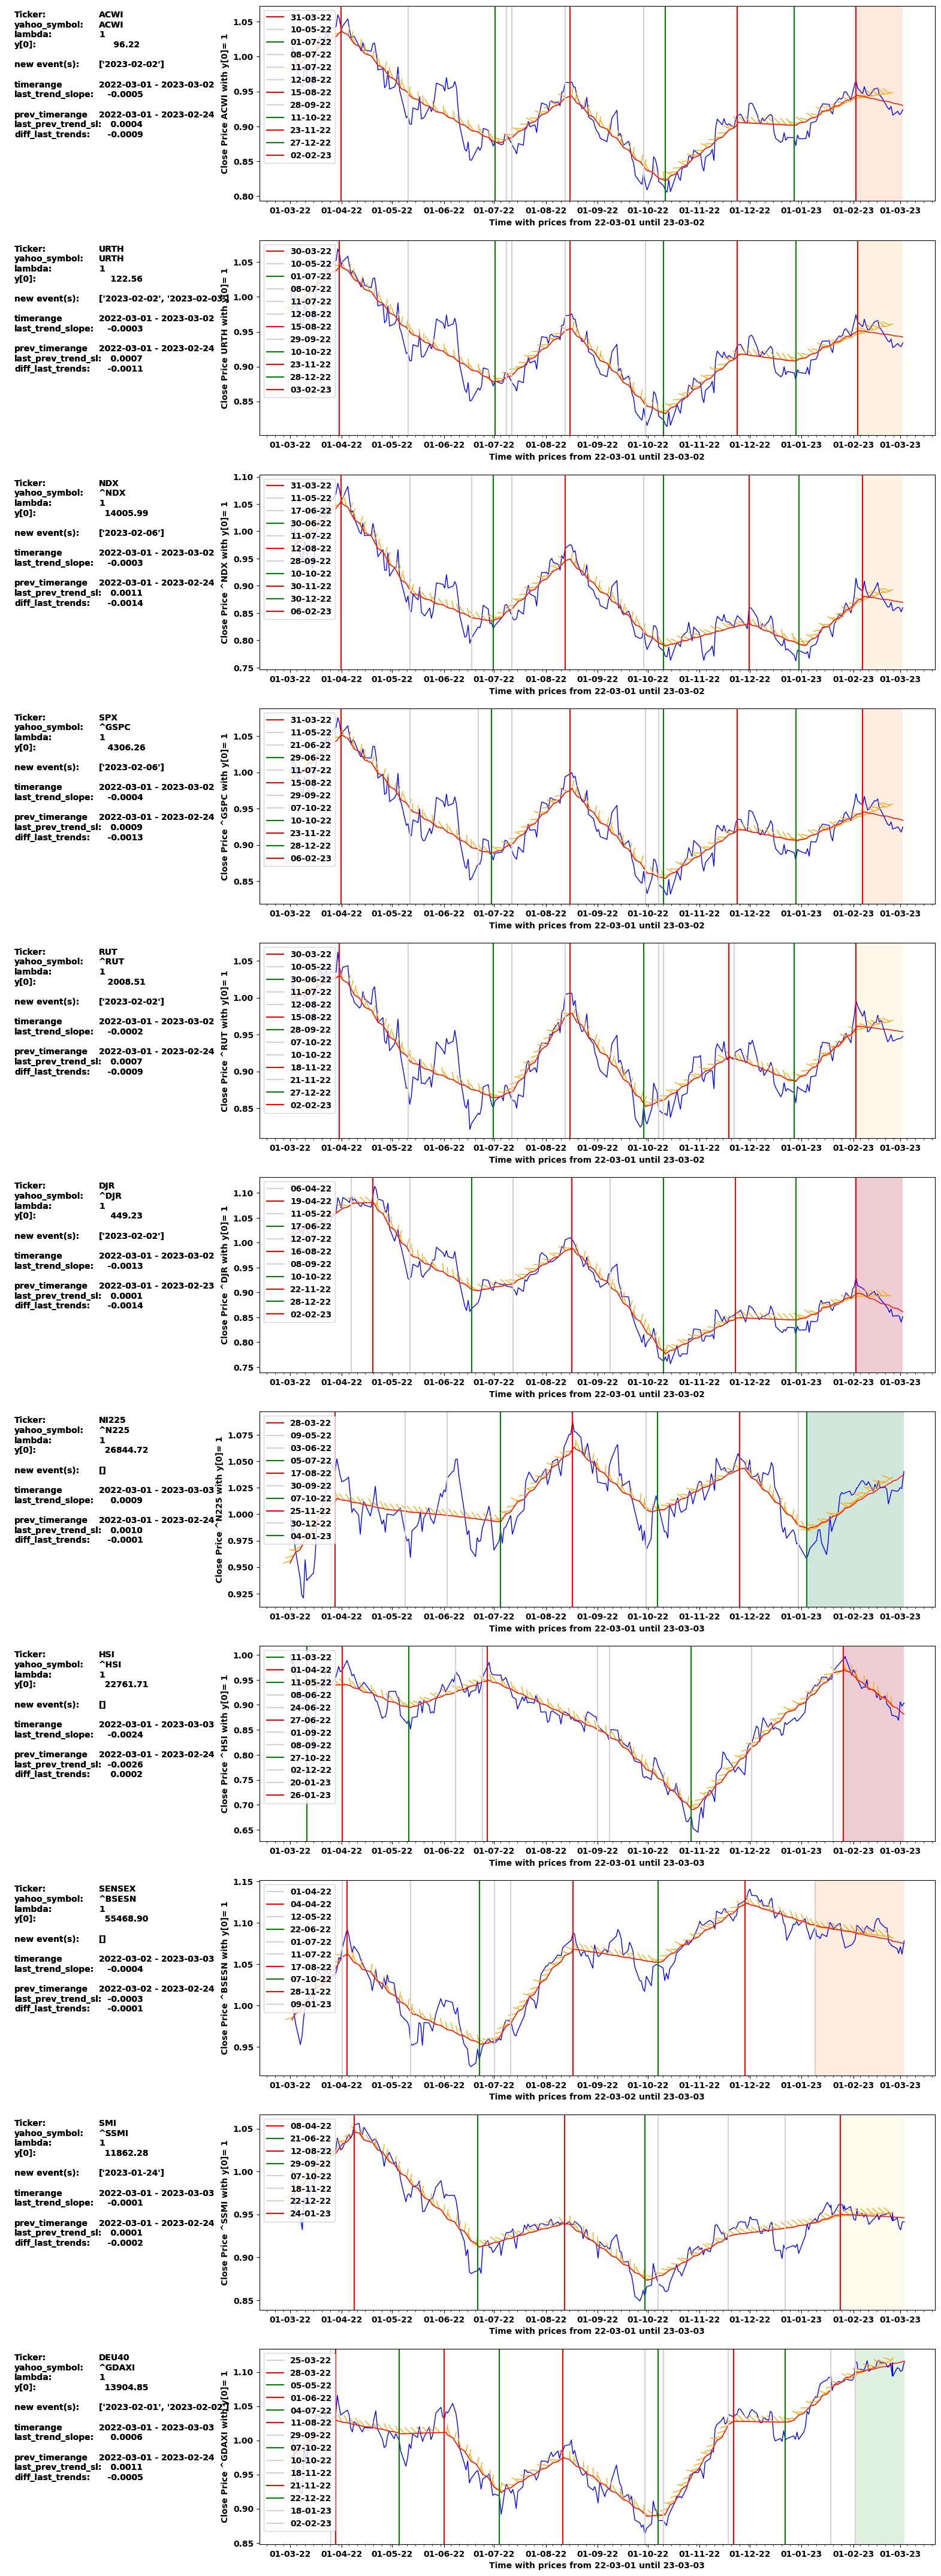

In [11]:
# Darstellung
# creates a figure with multiple subplots in the form of a grid, where the number of rows is determined by the length of two lists: trendlinedl and trendlinedll. The grid's width ratio is set to 1:4
fig, ax = plt.subplots(len(trendlinedl)*len(trendlinedll),2,squeeze=False, figsize=(20,num_runs*5), gridspec_kw={'width_ratios': [1, 4]})
#fig.subplots_adjust(top=0.96)
#fig.suptitle('Trendfilter L1 with lines(red=actual/orange=previous) and events')
#fig.tight_layout()
#ax = ax.ravel()
#fig.autofmt_xdate()
# A normalize function is created using matplotlib.colors.Normalize to set the minimum and maximum values for the color map. A color map cm.RdYlGn is created using the cm.ScalarMappable class.
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
#norm = matplotlib.colors.LogNorm(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdYlGn )

# A nested loop is then used to plot the close prices, trend lines and trend changes on each subplot. The outer loop iterates through trendlinedl and trendlinedll, and the inner loop iterates through each element in the lists. For each iteration, the close prices and trend lines are plotted on the subplot. The x-axis is labeled with the minimum and maximum dates of the trend lines. The y-axis is labeled with the close price of the symbol.
for j, (pricesd, trendlinedl, trendchangesdl, prev_pricesd, prev_trendlinedl, prev_trendchangesdl) in enumerate(zip(pricesdl,trendlinedll,trendchangesdll, prev_pricesdl,prev_trendlinedll,prev_trendchangesdll)):
    # j symbol iter 
    # def plot_trendlines_prices(fig, ax, pricesl, trendlinedl, trendchangesdl):
    for i, (trendlined, trendchangesd, prev_trendlined, prev_trendchangesd) in enumerate(zip(trendlinedl, trendchangesdl, prev_trendlinedl, prev_trendchangesdl)):
        # i lambda iter
        row = (j+(i*len(trendlinedl))+i)
        if row > 0:
            ax[row,1].get_shared_x_axes().join(ax[0,1], ax[row,1])
            #ax[row,1].get_shared_y_axes().join(ax[0,1], ax[row,1])
        
        #ax[row,1].plot(pricesd, linewidth=1.0, c='blue')
        plotprice = pricesd['close_start_1']
        plotprice.index = index= pd.to_datetime(pricesd['date'])
                                                
        ax[row,1].plot(plotprice, linewidth=1.0, c='blue')
        ax[row,1].plot(prev_trendlined, '-', linewidth=1.0, c='orange', path_effects=[patheffects.withTickedStroke(spacing=7, angle=135)])
        ax[row,1].plot(trendlined, '-', linewidth=1.0, c='red')
        
        mindt = trendlined.index.min().strftime('%y-%m-%d')
        maxdt = trendlined.index.max().strftime('%y-%m-%d')
        ax[row,1].set_xlabel(f'Time with prices from {mindt} until {maxdt}')
        ax[row,1].set_ylabel('Close Price ' + controllist['yahoo_symbol'][j] + ' with y[0]= 1')
        #ax[row,1].set_title(controllist['yahoo_symbol'][j] + ' with lambda=' + str(lambda_list[i]), loc='left')

        # The trend changes are then plotted using axvline and their positions are stored in the trendchangeslabel list. The legend is set to display the dates of the trend changes. The x-axis is also formatted to display the major and minor tick marks as months and days, respectively.
        # trendchangeslabel = []
        # for xv in prev_trendchangesd:
        #     ax[row,1].axvline(x=xv, c='orange', path_effects=[patheffects.withTickedStroke(spacing=7, angle=135)])        
        # for id, xv in enumerate(trendchangesd):
        #     trendchangeslabel.append(ax[row,1].axvline(x=xv, c='lightgrey'))
            # if id == len(trendchangesd)-1:
            #     ax[row,1].axvspan(trendchangesd.iloc[(id)], trendlined.index.max(), facecolor='red', alpha=0.2 )
            #     #'RdYlGn'

        # calc Buy/Sell signals
        aggtrendchangeslabel = []
        aggtchanges = calc_bs_signals(trendchangesd, trendlined)
        for index, s in aggtchanges[(aggtchanges['date'] != aggtchanges['date'].max()) & (aggtchanges['date'] != aggtchanges['date'].min())].iterrows():
            #print(type(s['buy']) + type(index))
            if s['buy']==True: 
                aggtrendchangeslabel.append(ax[row,1].axvline(x=s['date'] , c='green'))
            elif s['sell']==True: 
                aggtrendchangeslabel.append(ax[row,1].axvline(x=s['date'] , c='red'))
            else: #elif (s['date'] != aggtchanges['date'].min()) or (s['date'] != aggtchanges['date'].max()):
                aggtrendchangeslabel.append(ax[row,1].axvline(x=s['date'] , c='lightgrey'))

        #ax[row,1].set_title('Lambda: {}\nSolver: {}\nObjective Value: {}'.format(lambda_value, problem.status, round(objective.value, 3)))
        ax[row,1].xaxis.set_major_locator(mdates.MonthLocator())
        ax[row,1].xaxis.set_minor_locator(mdates.DayLocator(bymonthday=(1,5,10,15,20,25,30)))
        ax[row,1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))#('%b %d'))
        #ax[row,1].legend(trendchangeslabel, trendchangesd.dt.strftime('%y-%m-%d'), loc ="upper left", )
        #ax[row,1].legend(trendchangeslabel, aggtchanges[(aggtchanges.buy == True)| (aggtchanges.sell == True)].index.strftime('%y-%m-%d'), loc ="upper left", )
        ax[row,1].legend(aggtrendchangeslabel, aggtchanges[(aggtchanges['date'] != aggtchanges['date'].max()) & (aggtchanges['date'] != aggtchanges['date'].min())].index.strftime('%d-%m-%y'), loc ="upper left", )

        new_trendchnga, diff_st_trend, st_trend, st_prev_trend = calc_slope_diff(trendchangesd, prev_trendchangesd, trendlined, prev_trendlined)
        
        ax[row,1].axvspan(trendchangesd.max(), trendlined.index.max(), facecolor=mapper.to_rgba(1000*st_trend) , alpha=0.2 )

        ax[row,0].set_axis_off()
        new_trendchngs = [pd.to_datetime(str(x)).strftime('%Y-%m-%d') for x in new_trendchnga]
        # ax[row,0].text(0,0.8, 'new event(s):' + str(new_trendchngs), ha='left', size='x-large', wrap=True, transform=ax[row,0].transAxes)
        # ax[row,0].text(0,0.6, 'diff_st_trend:' + '{:10.4f}'.format(diff_st_trend) , ha='left', size='large', wrap=True, transform=ax[row,0].transAxes)
        # ax[row,0].text(0,0.4, 'st_trend:' + '{:10.4f}'.format(st_trend), ha='left', size='large', wrap=True, transform=ax[row,0].transAxes)
        # ax[row,0].text(0,0.2, 'st_prev_trend:' + '{:10.4f}'.format(st_prev_trend), ha='left', size='large', wrap=True, transform=ax[row,0].transAxes)

        cell_text = []
        cell_text.append(['Ticker:' , controllist['tradv_ticker'][j]])
        cell_text.append(['yahoo_symbol:' , controllist['yahoo_symbol'][j]])
        cell_text.append(['lambda:' , str(lambda_list[i])])
        cell_text.append(['y[0]:' , '{:10.2f}'.format(pricesd['close'][0])])
        cell_text.append(['' , ''])
        cell_text.append(['new event(s):', str(new_trendchngs)])
        cell_text.append(['' , ''])
        #cell_text.append(['timerange', pricesd.index.min().strftime('%Y-%m-%d')+ ' - ' + pricesd.index.max().strftime('%Y-%m-%d')])
        cell_text.append(['timerange', pd.to_datetime(pricesd['date']).min().strftime('%Y-%m-%d')+ ' - ' + pd.to_datetime(pricesd['date']).max().strftime('%Y-%m-%d')])
        cell_text.append(['last_trend_slope:' , '{:10.4f}'.format(st_trend)])
        cell_text.append(['' , ''])
        cell_text.append(['prev_timerange', pd.to_datetime(prev_pricesd['date']).min().strftime('%Y-%m-%d')+ ' - ' + pd.to_datetime(prev_pricesd['date']).max().strftime('%Y-%m-%d')])
        cell_text.append(['last_prev_trend_sl:' , '{:10.4f}'.format(st_prev_trend)])
        cell_text.append(['diff_last_trends:', '{:10.4f}'.format(diff_st_trend)])
        

        #ax[row,0].table(cellText=cell_text, loc='left')

        the_table = ax[row,0].table(cellText=cell_text, loc='upper center', edges='open', cellLoc='left')
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(10)
        #the_table.set_text_props(set_fontweight('light'))

        #the_table.scale(2,2)
        #the_table.visible_edges = 'B'
        ax[row,0].add_table(the_table)

ENDE

verschiedene Versuche

wie soll das aussehen

dargestellt werden soll:

<ul> <li>gibt es ein neues Event
<ul> 
    <li>wie lange ist das Event her
    <li>ist die Steigung stark unterschiedlich zur vorherigen Linie (nie?)
    </ul> 
<li>welche Steigung hat die letzte Linie
<li>welche Steigungsänderung hat die letzte Linie zum vorherigen run
</ul>

Könnte man eine Heatmap daraus machen?
Eigentlich müsste die Steigungsänderung viel früher ein Indikator für eine Änderung sein als ein neues Event

Die Steigungsänderung wäre also viel wichtiger, das Event ist dann nur noch die Bestätigung

Heatmapblock:
<ul> 
    <li>symbol, ccy, steigung
    <li>event1, steigungsänderung zu steigung
    <li>event2, steigungsänderung zu steigung
</ul>

Nachrichten klassifizieren mit FinBERT
https://arxiv.org/pdf/1908.10063v1.pdf

as mentioned in Listen Closely: Using Vocal Cues to Predict Future Earnings
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4307178

FinBERT Variables (Huang et al. 2022)
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3910214
Installationsanweisungen Seite 65


<ul> <li>
Environmental topic Captures content related to environmental topics.
<li>Governance topic Captures content related to governance topics.
<li>Social topic Captures content related to social topics.
<li>Specific fls Captures the fraction of specific forward-looking statements.
<li>Nonspecific fls Captures the fraction of nonspecific forward-looking statements.
<li>Tone net Captures neutral tone.
<li>Tone positive Captures positive tone.
<li>Tone negative Captures negative tone.
 </li></ul>

Stabiliäts test

In [ ]:
# stability test 
# test when trendchange shows up and stability of previous trendchanges with new data
prices_sorted.shape
dist_stability_runs = 5
num_runs = 10
index_stability_runs = range(prices_sorted.shape[0]-(dist_stability_runs*num_runs),prices_sorted.shape[0]+1,dist_stability_runs)
pricesdl = []
trendlinedll = []
trendchangesdll = []
for i in index_stability_runs:
    print(prices_sorted.iloc[0:i,:].shape)
    prices = prices_sorted.iloc[0:i,:]
    pricesd, trendlinedl, trendchangesdl = transform_calc_trendlines(prices, lambda_list, solver, reg_norm)
    pricesdl.append(pricesd)
    trendlinedll.append(trendlinedl)
    trendchangesdll.append(trendchangesdl)

#return pricesdl, trendlinedll, trendchangesdll


(230, 9)
(235, 9)
(240, 9)
(245, 9)
(250, 9)
(255, 9)
(260, 9)
(265, 9)
(270, 9)
(275, 9)
(280, 9)
